In [52]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')


In [53]:
# ML Imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             accuracy_score, precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb


In [54]:
# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*70)
print("MODEL BUILDING NOTEBOOK - INITIALIZED")
print("="*70)


MODEL BUILDING NOTEBOOK - INITIALIZED


## Load Processed Data

In [55]:
# Load processed data
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

In [56]:
# Load scaled versions
X_train_scaled = pd.read_csv('../data/processed/X_train_scaled.csv')
X_test_scaled = pd.read_csv('../data/processed/X_test_scaled.csv')

In [57]:
print("-" * 70)
print(f"Training Set:")
print(f"  Features (X_train): {X_train.shape}")
print(f"  Target (y_train):   {y_train.shape}")
print(f"  Fraud:     {y_train.sum():,} ({y_train.mean()*100:.4f}%)")
print(f"  Non-Fraud: {(~y_train.astype(bool)).sum():,}")

print(f"\nTest Set:")
print(f"  Features (X_test): {X_test.shape}")
print(f"  Target (y_test):   {y_test.shape}")
print(f"  Fraud:     {y_test.sum():,} ({y_test.mean()*100:.4f}%)")
print(f"  Non-Fraud: {(~y_test.astype(bool)).sum():,}")

----------------------------------------------------------------------
Training Set:
  Features (X_train): (5090096, 15)
  Target (y_train):   (5090096,)
  Fraud:     13 (0.0003%)
  Non-Fraud: 5,090,083

Test Set:
  Features (X_test): (1272524, 15)
  Target (y_test):   (1272524,)
  Fraud:     3 (0.0002%)
  Non-Fraud: 1,272,521


## Helper Functions

In [58]:
print("\n" + "="*70)
print("DEFINING EVALUATION FUNCTIONS")
print("="*70)

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive model evaluation function
    
    Returns: Dictionary with all metrics and predictions
    """
    print(f"\n{'='*70}")
    print(f"{model_name.upper()} - EVALUATION RESULTS")
    print(f"{'='*70}")
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Probabilities (if available)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    except:
        roc_auc = 0.0
    
    # Print metrics
    print(f"\n PERFORMANCE METRICS:")
    print(f"-" * 70)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}  (Of predicted frauds, how many are correct?)")
    print(f"Recall:    {recall:.4f}  (Of actual frauds, how many did we catch?)")
    print(f"F1-Score:  {f1:.4f}  (Harmonic mean of precision and recall)")
    print(f"ROC-AUC:   {roc_auc:.4f}  (Overall model discrimination ability)")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n CONFUSION MATRIX:")
    print(f"-" * 70)
    
    if cm.sum() > 0 and cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        print(f"True Negatives (Correct Non-Fraud):  {tn:>10,}")
        print(f"False Positives (False Alarms):      {fp:>10,}")
        print(f"False Negatives (Missed Frauds):     {fn:>10,}")
        print(f"True Positives (Caught Frauds):      {tp:>10,}")
        
        print(f"\n💡 BUSINESS IMPACT:")
        print(f"-" * 70)
        if tp + fn > 0:
            print(f"Frauds Detected: {tp}/{tp+fn} ({tp/(tp+fn)*100:.1f}%)")
        if fp + tn > 0:
            print(f"False Alarm Rate: {fp/(fp+tn)*100:.4f}%")
    
    # Classification Report
    print(f"\n DETAILED CLASSIFICATION REPORT:")
    print(f"-" * 70)
    print(classification_report(y_test, y_pred, zero_division=0, 
                                target_names=['Non-Fraud', 'Fraud']))
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': cm
    }


def plot_confusion_matrix(cm, model_name):
    """Plot confusion matrix heatmap"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=',.0f', cmap='Blues', 
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_roc_curve(results_list):
    """Plot ROC curves for multiple models"""
    plt.figure(figsize=(10, 8))
    
    for result in results_list:
        if result['roc_auc'] > 0:
            fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
            plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC={result['roc_auc']:.4f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n Evaluation functions defined!")


DEFINING EVALUATION FUNCTIONS

 Evaluation functions defined!


# Part 1 - Logistic Regression (Baseline)


PART 1: BASELINE MODEL - LOGISTIC REGRESSION

 Training Logistic Regression with balanced class weights...
 Model trained!

LOGISTIC REGRESSION - EVALUATION RESULTS

 PERFORMANCE METRICS:
----------------------------------------------------------------------
Accuracy:  0.9999
Precision: 0.0297  (Of predicted frauds, how many are correct?)
Recall:    1.0000  (Of actual frauds, how many did we catch?)
F1-Score:  0.0577  (Harmonic mean of precision and recall)
ROC-AUC:   1.0000  (Overall model discrimination ability)

 CONFUSION MATRIX:
----------------------------------------------------------------------
True Negatives (Correct Non-Fraud):   1,272,423
False Positives (False Alarms):              98
False Negatives (Missed Frauds):              0
True Positives (Caught Frauds):               3

💡 BUSINESS IMPACT:
----------------------------------------------------------------------
Frauds Detected: 3/3 (100.0%)
False Alarm Rate: 0.0077%

 DETAILED CLASSIFICATION REPORT:
---------------

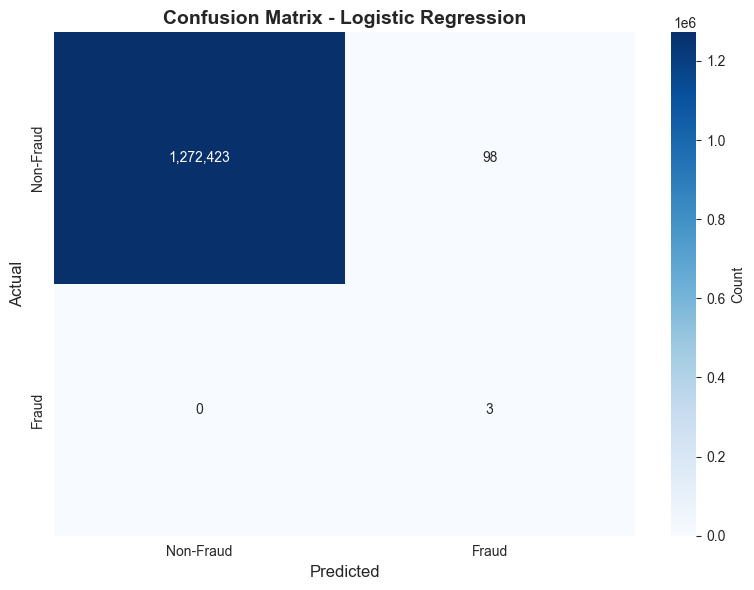

In [59]:
print("\n" + "="*70)
print("PART 1: BASELINE MODEL - LOGISTIC REGRESSION")
print("="*70)

print("\n Training Logistic Regression with balanced class weights...")

# Train model
lr_model = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced',  # Handle imbalance
    solver='liblinear'
)

lr_model.fit(X_train_scaled, y_train)
print(" Model trained!")

# Evaluate
lr_results = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")

# Plot confusion matrix
plot_confusion_matrix(lr_results['confusion_matrix'], "Logistic Regression")

# Store results for later comparison
all_results = [lr_results]

# Part 2 - Random Forest (Default)


PART 2: RANDOM FOREST - DEFAULT SETTINGS

 Training Random Forest with default settings...
 Model trained!

RANDOM FOREST (DEFAULT) - EVALUATION RESULTS

 PERFORMANCE METRICS:
----------------------------------------------------------------------
Accuracy:  1.0000
Precision: 1.0000  (Of predicted frauds, how many are correct?)
Recall:    0.6667  (Of actual frauds, how many did we catch?)
F1-Score:  0.8000  (Harmonic mean of precision and recall)
ROC-AUC:   1.0000  (Overall model discrimination ability)

 CONFUSION MATRIX:
----------------------------------------------------------------------
True Negatives (Correct Non-Fraud):   1,272,521
False Positives (False Alarms):               0
False Negatives (Missed Frauds):              1
True Positives (Caught Frauds):               2

💡 BUSINESS IMPACT:
----------------------------------------------------------------------
Frauds Detected: 2/3 (66.7%)
False Alarm Rate: 0.0000%

 DETAILED CLASSIFICATION REPORT:
----------------------------

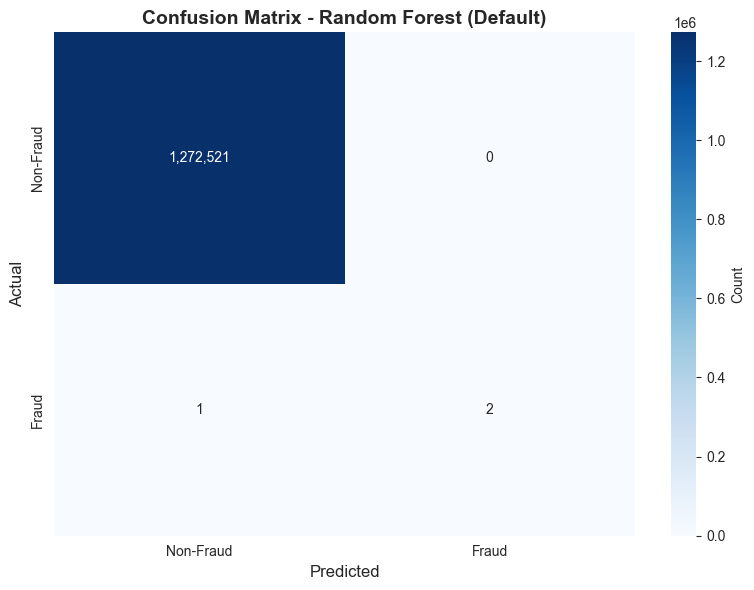

In [60]:
print("\n" + "="*70)
print("PART 2: RANDOM FOREST - DEFAULT SETTINGS")
print("="*70)

print("\n Training Random Forest with default settings...")

# Train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train, y_train)
print(" Model trained!")

# Evaluate
rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest (Default)")

# Plot confusion matrix
plot_confusion_matrix(rf_results['confusion_matrix'], "Random Forest (Default)")

# Store results
all_results.append(rf_results)

# Part 3 - Feature Importance (Random Forest)


FEATURE IMPORTANCE ANALYSIS

 Top 10 Most Important Features:
----------------------------------------------------------------------
                feature  importance
      balanceChangeOrig    0.262537
          oldbalanceOrg    0.167592
amountToOldBalanceRatio    0.165428
                 amount    0.120452
         newbalanceOrig    0.097726
    amountMatchesChange    0.064544
                    day    0.030085
          originEmptied    0.027283
           type_encoded    0.019406
                   hour    0.014807


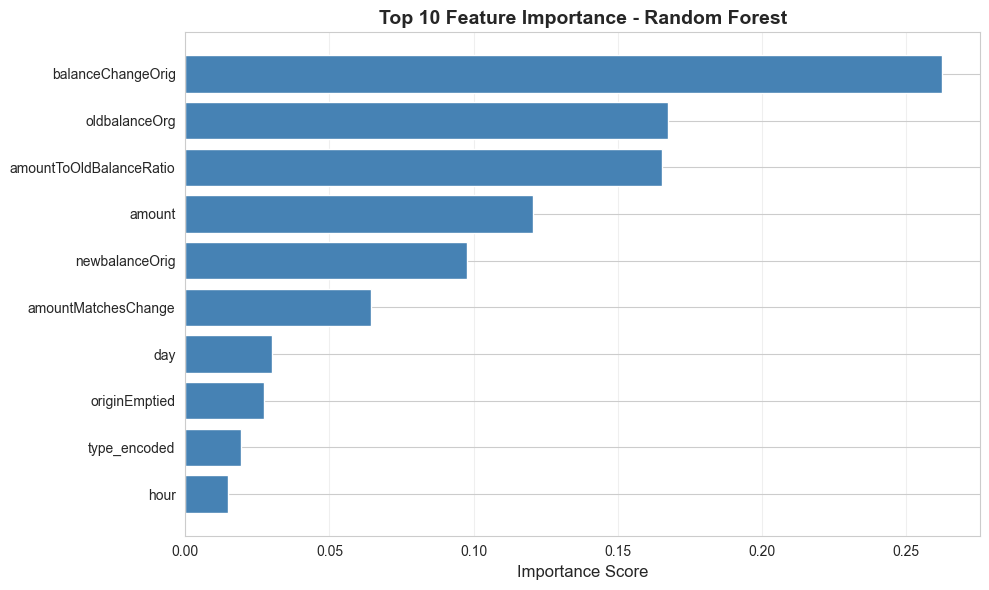

In [61]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 10 Most Important Features:")
print("-" * 70)
print(feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# PART 4 - Random Forest (Balanced Class Weights)


PART 3: RANDOM FOREST - BALANCED CLASS WEIGHTS

 Training Random Forest with balanced class weights...
This gives more importance to the minority class (fraud)...
 Model trained!

RANDOM FOREST (BALANCED) - EVALUATION RESULTS

 PERFORMANCE METRICS:
----------------------------------------------------------------------
Accuracy:  1.0000
Precision: 1.0000  (Of predicted frauds, how many are correct?)
Recall:    1.0000  (Of actual frauds, how many did we catch?)
F1-Score:  1.0000  (Harmonic mean of precision and recall)
ROC-AUC:   1.0000  (Overall model discrimination ability)

 CONFUSION MATRIX:
----------------------------------------------------------------------
True Negatives (Correct Non-Fraud):   1,272,521
False Positives (False Alarms):               0
False Negatives (Missed Frauds):              0
True Positives (Caught Frauds):               3

💡 BUSINESS IMPACT:
----------------------------------------------------------------------
Frauds Detected: 3/3 (100.0%)
False Alarm Ra

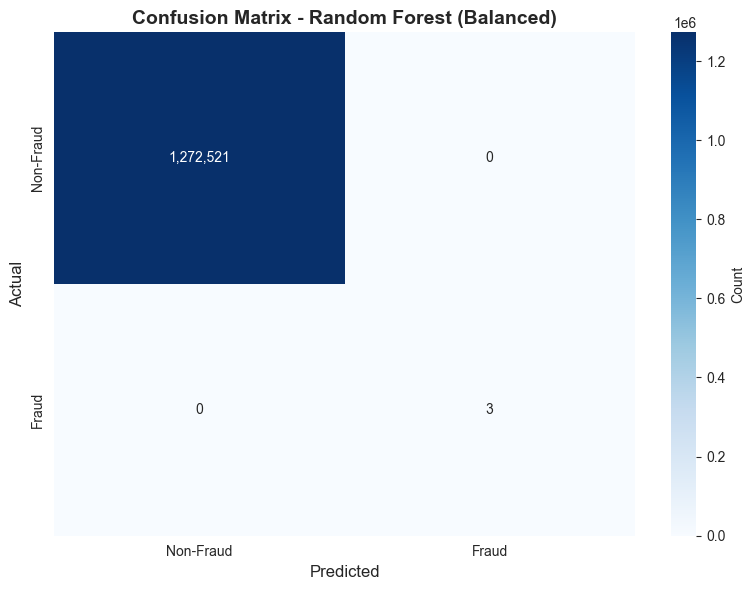

In [62]:
print("\n" + "="*70)
print("PART 3: RANDOM FOREST - BALANCED CLASS WEIGHTS")
print("="*70)

print("\n Training Random Forest with balanced class weights...")
print("This gives more importance to the minority class (fraud)...")

# Train model
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',  # Key difference!
    n_jobs=-1,
    verbose=0
)

rf_balanced.fit(X_train, y_train)
print(" Model trained!")

# Evaluate
rf_balanced_results = evaluate_model(rf_balanced, X_test, y_test, 
                                     "Random Forest (Balanced)")

# Plot confusion matrix
plot_confusion_matrix(rf_balanced_results['confusion_matrix'], 
                     "Random Forest (Balanced)")

# Store results
all_results.append(rf_balanced_results)

# Part 5 - Apply SMOTE

In [63]:
print("\n" + "="*70)
print("PART 4: HANDLING IMBALANCE WITH SMOTE")
print("="*70)

print("\n Applying SMOTE (Synthetic Minority Over-sampling Technique)...")
print("Original training distribution:")
print(f"  Fraud:     {y_train.sum():,}")
print(f"  Non-Fraud: {(~y_train.astype(bool)).sum():,}")

# Apply SMOTE with conservative sampling
# We use 0.01 (1%) to avoid creating too many synthetic samples
smote = SMOTE(sampling_strategy=0.01, random_state=42, k_neighbors=5)

print("\n Generating synthetic samples...")
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n SMOTE completed!")
print(f"After SMOTE:")
print(f"  Fraud:     {y_train_smote.sum():,}")
print(f"  Non-Fraud: {(~y_train_smote.astype(bool)).sum():,}")
print(f"  Total samples: {len(y_train_smote):,}")
print(f"  Fraud percentage: {y_train_smote.mean()*100:.2f}%")


PART 4: HANDLING IMBALANCE WITH SMOTE

 Applying SMOTE (Synthetic Minority Over-sampling Technique)...
Original training distribution:
  Fraud:     13
  Non-Fraud: 5,090,083

 Generating synthetic samples...

 SMOTE completed!
After SMOTE:
  Fraud:     50,900
  Non-Fraud: 5,090,083
  Total samples: 5,140,983
  Fraud percentage: 0.99%


# Part 6 - Randon Forest on SMOTE Data


PART 5: RANDOM FOREST - TRAINED ON SMOTE DATA

 Training Random Forest on SMOTE-balanced data...
 Model trained!

RANDOM FOREST (SMOTE) - EVALUATION RESULTS

 PERFORMANCE METRICS:
----------------------------------------------------------------------
Accuracy:  1.0000
Precision: 1.0000  (Of predicted frauds, how many are correct?)
Recall:    1.0000  (Of actual frauds, how many did we catch?)
F1-Score:  1.0000  (Harmonic mean of precision and recall)
ROC-AUC:   1.0000  (Overall model discrimination ability)

 CONFUSION MATRIX:
----------------------------------------------------------------------
True Negatives (Correct Non-Fraud):   1,272,521
False Positives (False Alarms):               0
False Negatives (Missed Frauds):              0
True Positives (Caught Frauds):               3

💡 BUSINESS IMPACT:
----------------------------------------------------------------------
Frauds Detected: 3/3 (100.0%)
False Alarm Rate: 0.0000%

 DETAILED CLASSIFICATION REPORT:
-----------------------

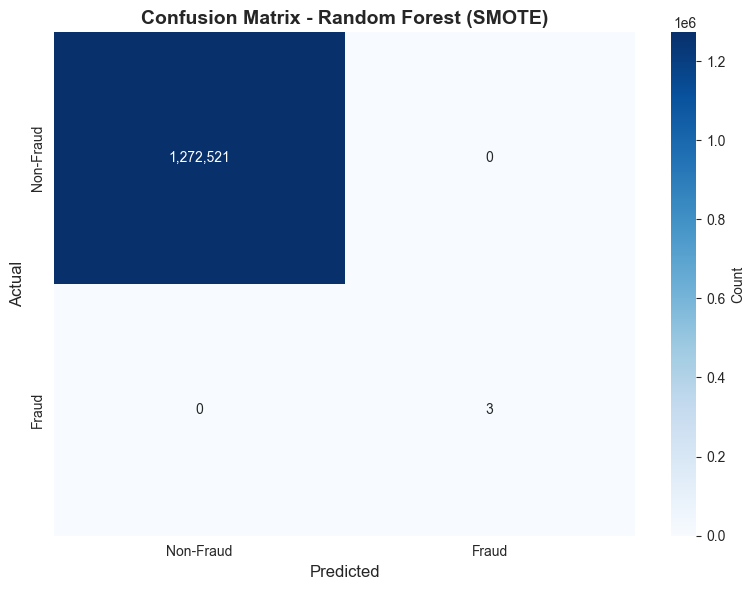

In [64]:
print("\n" + "="*70)
print("PART 5: RANDOM FOREST - TRAINED ON SMOTE DATA")
print("="*70)

print("\n Training Random Forest on SMOTE-balanced data...")

# Train model
rf_smote = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_smote.fit(X_train_smote, y_train_smote)
print(" Model trained!")

# Evaluate (still test on original unbalanced test set)
rf_smote_results = evaluate_model(rf_smote, X_test, y_test, 
                                  "Random Forest (SMOTE)")

# Plot confusion matrix
plot_confusion_matrix(rf_smote_results['confusion_matrix'], 
                     "Random Forest (SMOTE)")

# Store results
all_results.append(rf_smote_results)

# Part 7 - XGBoost (Defult)


PART 6: XGBOOST - DEFAULT SETTINGS

 Training XGBoost with default settings...
 Model trained!

XGBOOST (DEFAULT) - EVALUATION RESULTS

 PERFORMANCE METRICS:
----------------------------------------------------------------------
Accuracy:  1.0000
Precision: 1.0000  (Of predicted frauds, how many are correct?)
Recall:    1.0000  (Of actual frauds, how many did we catch?)
F1-Score:  1.0000  (Harmonic mean of precision and recall)
ROC-AUC:   1.0000  (Overall model discrimination ability)

 CONFUSION MATRIX:
----------------------------------------------------------------------
True Negatives (Correct Non-Fraud):   1,272,521
False Positives (False Alarms):               0
False Negatives (Missed Frauds):              0
True Positives (Caught Frauds):               3

💡 BUSINESS IMPACT:
----------------------------------------------------------------------
Frauds Detected: 3/3 (100.0%)
False Alarm Rate: 0.0000%

 DETAILED CLASSIFICATION REPORT:
---------------------------------------------

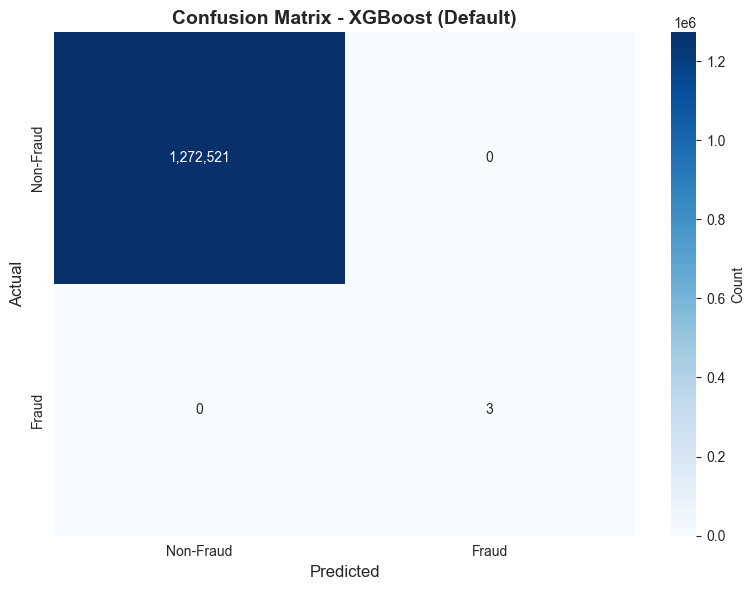

In [65]:
print("\n" + "="*70)
print("PART 6: XGBOOST - DEFAULT SETTINGS")
print("="*70)

print("\n Training XGBoost with default settings...")

# Train model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
print(" Model trained!")

# Evaluate
xgb_results = evaluate_model(xgb_model, X_test, y_test, "XGBoost (Default)")

# Plot confusion matrix
plot_confusion_matrix(xgb_results['confusion_matrix'], "XGBoost (Default)")

# Store results
all_results.append(xgb_results)


PART 7: XGBOOST - WITH SCALE_POS_WEIGHT (HANDLING IMBALANCE)

 Training XGBoost with scale_pos_weight...
scale_pos_weight = 391544.85
This tells XGBoost to give more importance to fraud samples.
 Model trained!

XGBOOST (BALANCED) - EVALUATION RESULTS

 PERFORMANCE METRICS:
----------------------------------------------------------------------
Accuracy:  1.0000
Precision: 0.7500  (Of predicted frauds, how many are correct?)
Recall:    1.0000  (Of actual frauds, how many did we catch?)
F1-Score:  0.8571  (Harmonic mean of precision and recall)
ROC-AUC:   1.0000  (Overall model discrimination ability)

 CONFUSION MATRIX:
----------------------------------------------------------------------
True Negatives (Correct Non-Fraud):   1,272,520
False Positives (False Alarms):               1
False Negatives (Missed Frauds):              0
True Positives (Caught Frauds):               3

💡 BUSINESS IMPACT:
----------------------------------------------------------------------
Frauds Detected: 3

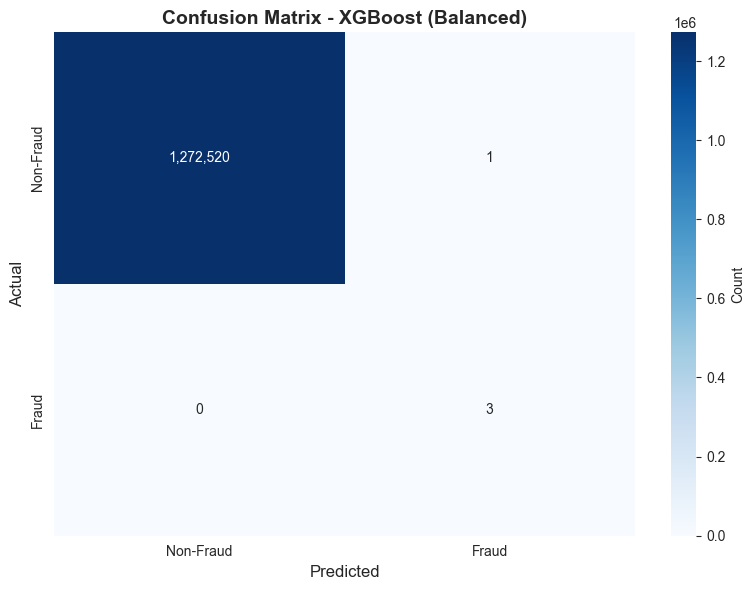

In [66]:
print("\n" + "="*70)
print("PART 7: XGBOOST - WITH SCALE_POS_WEIGHT (HANDLING IMBALANCE)")
print("="*70)

print("\n Training XGBoost with scale_pos_weight...")

# Calculate scale_pos_weight
# This is the ratio of negative to positive samples
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
print(f"scale_pos_weight = {scale_pos_weight:.2f}")
print("This tells XGBoost to give more importance to fraud samples.")

# Train model
xgb_balanced = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1
)

xgb_balanced.fit(X_train, y_train)
print(" Model trained!")

# Evaluate
xgb_balanced_results = evaluate_model(xgb_balanced, X_test, y_test, 
                                      "XGBoost (Balanced)")

# Plot confusion matrix
plot_confusion_matrix(xgb_balanced_results['confusion_matrix'], 
                     "XGBoost (Balanced)")

# Store results
all_results.append(xgb_balanced_results)


XGBOOST FEATURE IMPORTANCE

 Top 10 Most Important Features (XGBoost):
----------------------------------------------------------------------
                feature   importance
           type_encoded 8.681620e-01
         newbalanceOrig 1.304160e-01
      balanceChangeOrig 1.223466e-03
         newbalanceDest 1.749454e-04
                 amount 2.054829e-05
amountToOldBalanceRatio 1.507505e-06
          oldbalanceOrg 1.289794e-06
                    day 2.609012e-07
                   hour 1.422532e-08
         oldbalanceDest 0.000000e+00


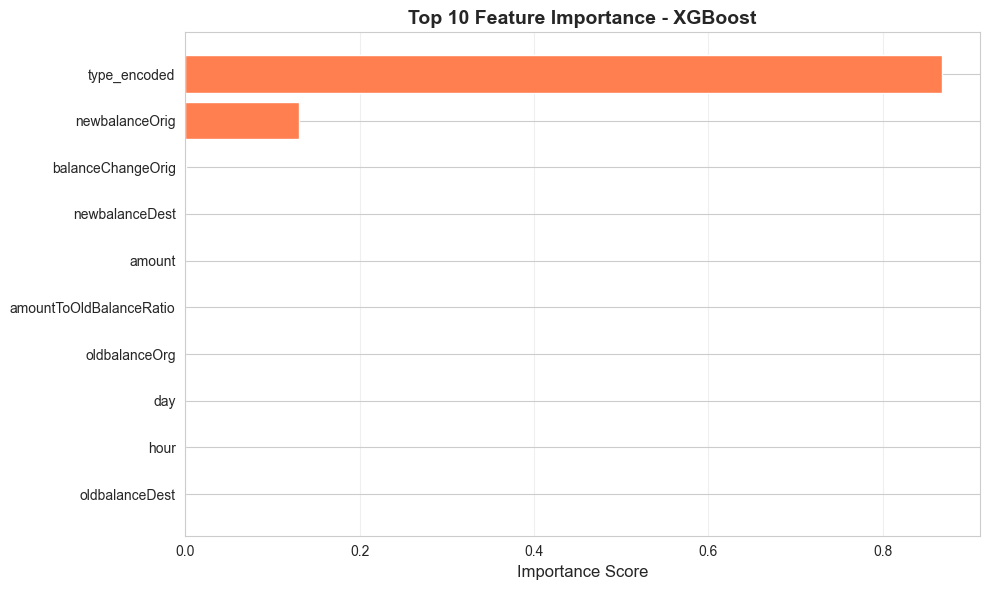

In [67]:
print("\n" + "="*70)
print("XGBOOST FEATURE IMPORTANCE")
print("="*70)

# Get feature importance
xgb_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_balanced.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 10 Most Important Features (XGBoost):")
print("-" * 70)
print(xgb_feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
top_features = xgb_feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='coral')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Feature Importance - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


PART 8: XGBOOST - TRAINED ON SMOTE DATA

 Training XGBoost on SMOTE-balanced data...
 Model trained!

XGBOOST (SMOTE) - EVALUATION RESULTS

 PERFORMANCE METRICS:
----------------------------------------------------------------------
Accuracy:  1.0000
Precision: 0.7500  (Of predicted frauds, how many are correct?)
Recall:    1.0000  (Of actual frauds, how many did we catch?)
F1-Score:  0.8571  (Harmonic mean of precision and recall)
ROC-AUC:   1.0000  (Overall model discrimination ability)

 CONFUSION MATRIX:
----------------------------------------------------------------------
True Negatives (Correct Non-Fraud):   1,272,520
False Positives (False Alarms):               1
False Negatives (Missed Frauds):              0
True Positives (Caught Frauds):               3

💡 BUSINESS IMPACT:
----------------------------------------------------------------------
Frauds Detected: 3/3 (100.0%)
False Alarm Rate: 0.0001%

 DETAILED CLASSIFICATION REPORT:
-----------------------------------------

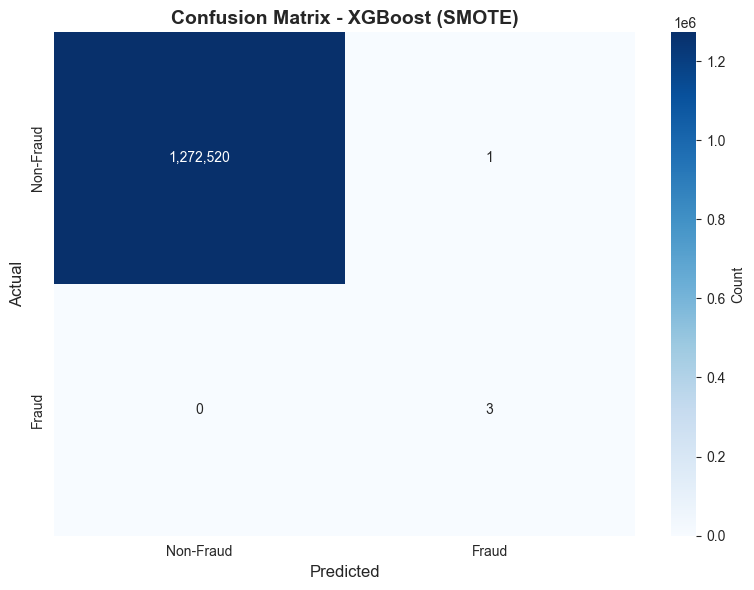

In [68]:
print("\n" + "="*70)
print("PART 8: XGBOOST - TRAINED ON SMOTE DATA")
print("="*70)

print("\n Training XGBoost on SMOTE-balanced data...")

# Train model
xgb_smote = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1
)

xgb_smote.fit(X_train_smote, y_train_smote)
print(" Model trained!")

# Evaluate
xgb_smote_results = evaluate_model(xgb_smote, X_test, y_test, 
                                   "XGBoost (SMOTE)")

# Plot confusion matrix
plot_confusion_matrix(xgb_smote_results['confusion_matrix'], 
                     "XGBoost (SMOTE)")

# Store results
all_results.append(xgb_smote_results)


COMPREHENSIVE MODEL COMPARISON

 MODEL PERFORMANCE SUMMARY:
                   Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Random Forest (Balanced)  1.000000   1.000000 1.000000  1.000000 1.000000
       XGBoost (Default)  1.000000   1.000000 1.000000  1.000000 1.000000
   Random Forest (SMOTE)  1.000000   1.000000 1.000000  1.000000 1.000000
      XGBoost (Balanced)  0.999999   0.750000 1.000000  0.857143 1.000000
         XGBoost (SMOTE)  0.999999   0.750000 1.000000  0.857143 1.000000
 Random Forest (Default)  0.999999   1.000000 0.666667  0.800000 1.000000
     Logistic Regression  0.999923   0.029703 1.000000  0.057692 0.999992

 BEST MODELS:
----------------------------------------------------------------------
                   Model  Precision  Recall  F1-Score
Random Forest (Balanced)        1.0     1.0       1.0
       XGBoost (Default)        1.0     1.0       1.0
   Random Forest (SMOTE)        1.0     1.0       1.0


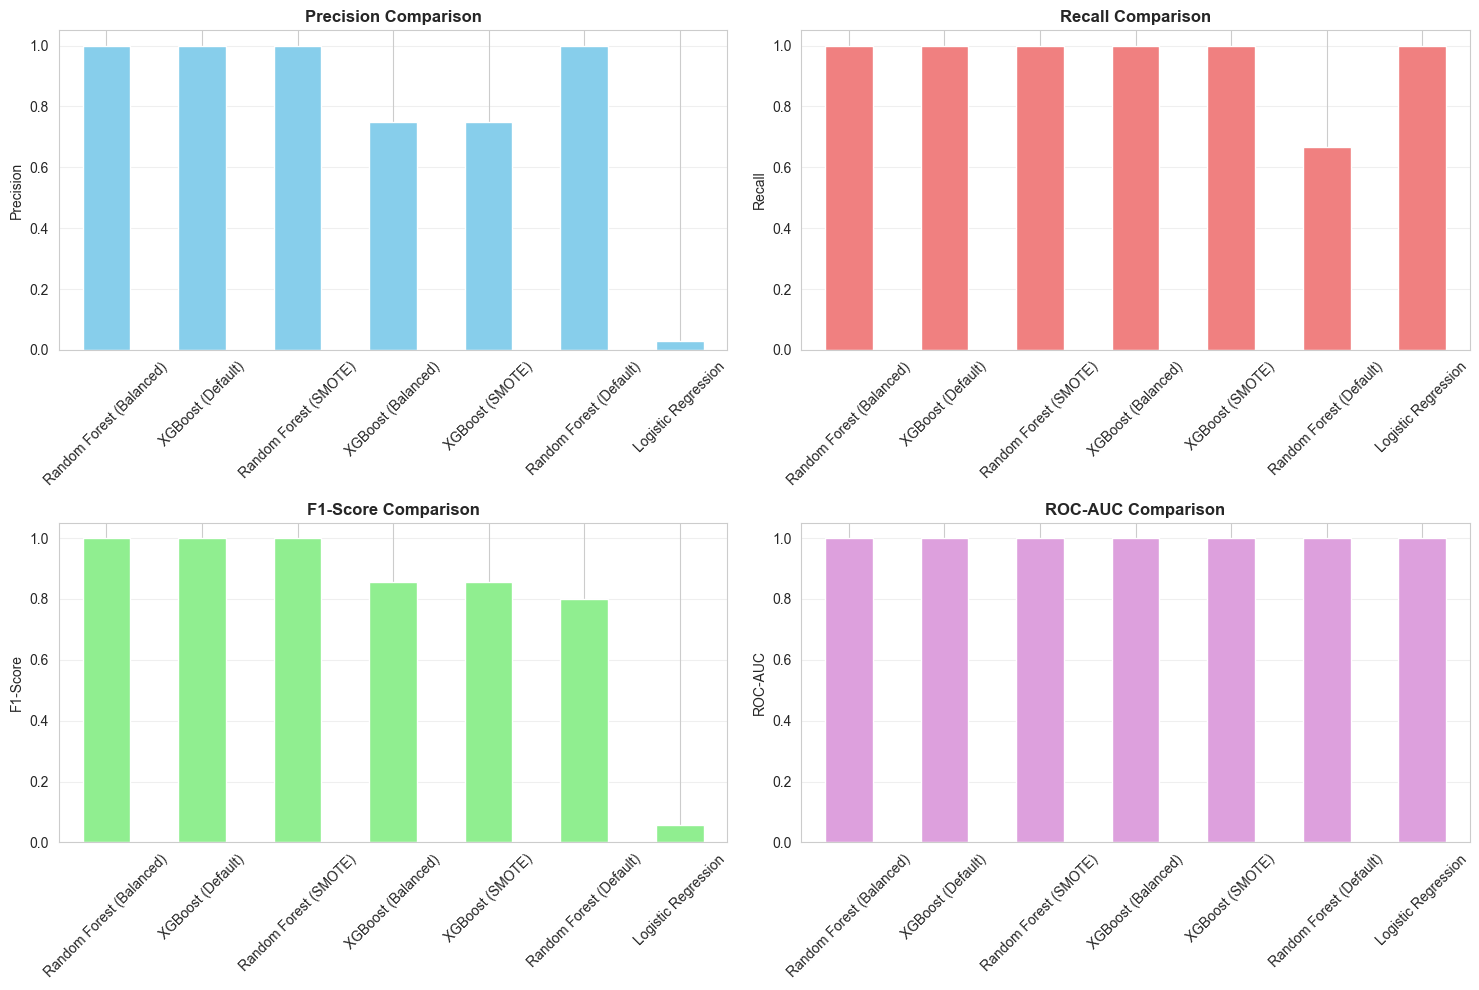

In [69]:
print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1'],
        'ROC-AUC': result['roc_auc']
    }
    for result in all_results
])

# Sort by F1-Score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n MODEL PERFORMANCE SUMMARY:")
print("="*70)
print(comparison_df.to_string(index=False))

# Highlight best models
print("\n BEST MODELS:")
print("-" * 70)
best_f1 = comparison_df['F1-Score'].max()
best_models = comparison_df[comparison_df['F1-Score'] == best_f1]
print(best_models[['Model', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Precision
ax1 = axes[0, 0]
comparison_df.plot(x='Model', y='Precision', kind='bar', ax=ax1, color='skyblue', legend=False)
ax1.set_title('Precision Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('Precision')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Recall
ax2 = axes[0, 1]
comparison_df.plot(x='Model', y='Recall', kind='bar', ax=ax2, color='lightcoral', legend=False)
ax2.set_title('Recall Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Recall')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: F1-Score
ax3 = axes[1, 0]
comparison_df.plot(x='Model', y='F1-Score', kind='bar', ax=ax3, color='lightgreen', legend=False)
ax3.set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
ax3.set_ylabel('F1-Score')
ax3.set_xlabel('')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: ROC-AUC
ax4 = axes[1, 1]
comparison_df.plot(x='Model', y='ROC-AUC', kind='bar', ax=ax4, color='plum', legend=False)
ax4.set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
ax4.set_ylabel('ROC-AUC')
ax4.set_xlabel('')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


ROC CURVE COMPARISON


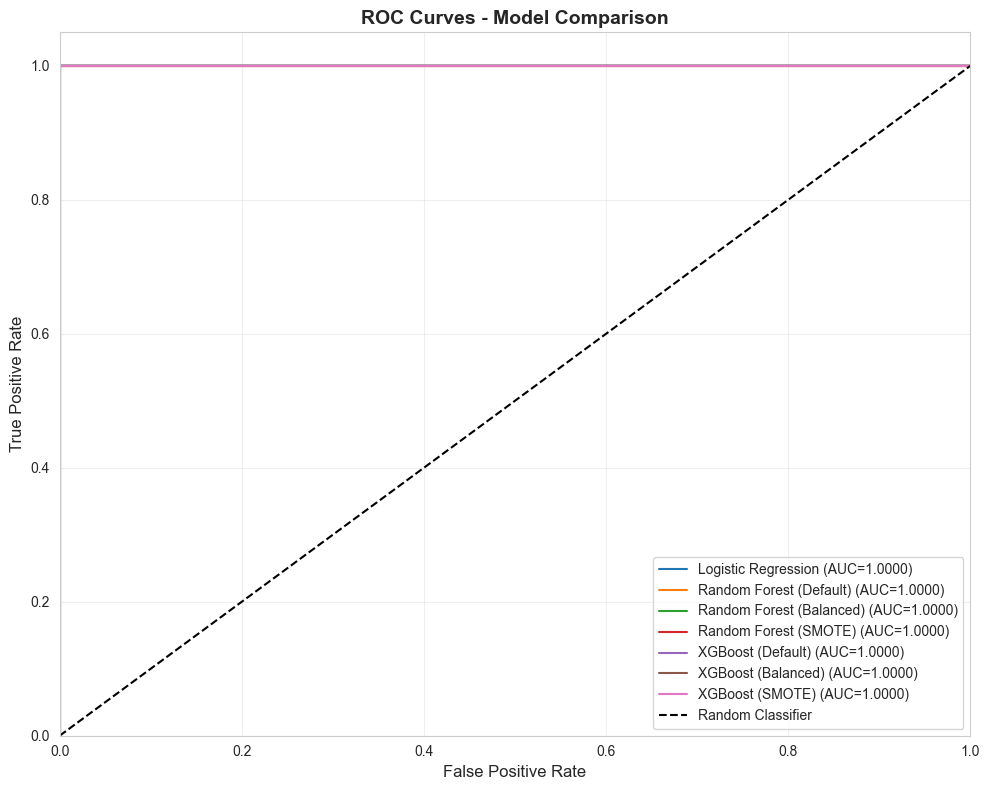

In [70]:
print("\n" + "="*70)
print("ROC CURVE COMPARISON")
print("="*70)

# Plot ROC curves for all models
plot_roc_curve(all_results)


CONFUSION MATRIX COMPARISON - FRAUD DETECTION SUMMARY

 FRAUD DETECTION PERFORMANCE:
                   Model  Frauds Caught (TP)  Frauds Missed (FN)  False Alarms (FP)  Correct Non-Fraud (TN)  Total Frauds  Detection Rate (%)
     Logistic Regression                   3                   0                 98                 1272423             3          100.000000
Random Forest (Balanced)                   3                   0                  0                 1272521             3          100.000000
   Random Forest (SMOTE)                   3                   0                  0                 1272521             3          100.000000
      XGBoost (Balanced)                   3                   0                  1                 1272520             3          100.000000
       XGBoost (Default)                   3                   0                  0                 1272521             3          100.000000
         XGBoost (SMOTE)                   3                  

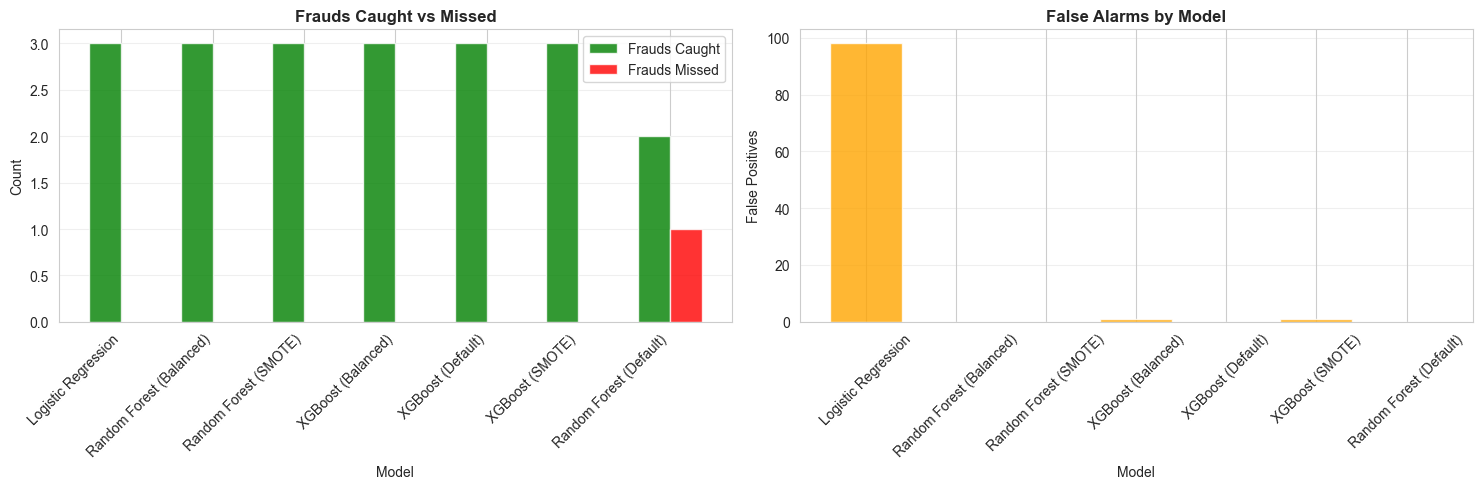

In [71]:
print("\n" + "="*70)
print("CONFUSION MATRIX COMPARISON - FRAUD DETECTION SUMMARY")
print("="*70)

# Create detailed fraud detection summary
fraud_detection_summary = []

for result in all_results:
    cm = result['confusion_matrix']
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        fraud_detection_summary.append({
            'Model': result['model_name'],
            'Frauds Caught (TP)': tp,
            'Frauds Missed (FN)': fn,
            'False Alarms (FP)': fp,
            'Correct Non-Fraud (TN)': tn,
            'Total Frauds': tp + fn,
            'Detection Rate (%)': (tp / (tp + fn) * 100) if (tp + fn) > 0 else 0
        })

fraud_summary_df = pd.DataFrame(fraud_detection_summary)
fraud_summary_df = fraud_summary_df.sort_values('Detection Rate (%)', ascending=False).reset_index(drop=True)

print("\n FRAUD DETECTION PERFORMANCE:")
print("="*70)
print(fraud_summary_df.to_string(index=False))

# Visualize fraud detection
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Frauds Caught vs Missed
ax1 = axes[0]
x = range(len(fraud_summary_df))
width = 0.35
ax1.bar([i - width/2 for i in x], fraud_summary_df['Frauds Caught (TP)'], 
        width, label='Frauds Caught', color='green', alpha=0.8)
ax1.bar([i + width/2 for i in x], fraud_summary_df['Frauds Missed (FN)'], 
        width, label='Frauds Missed', color='red', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('Count')
ax1.set_title('Frauds Caught vs Missed', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(fraud_summary_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: False Alarms
ax2 = axes[1]
ax2.bar(fraud_summary_df['Model'], fraud_summary_df['False Alarms (FP)'], 
        color='orange', alpha=0.8)
ax2.set_xlabel('Model')
ax2.set_ylabel('False Positives')
ax2.set_title('False Alarms by Model', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [72]:
print("\n" + "="*70)
print("SAVING BEST MODEL")
print("="*70)

# Determine best model based on F1-Score
best_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']

print(f"\n Best Model: {best_model_name}")
print(f"   F1-Score: {comparison_df.loc[best_idx, 'F1-Score']:.4f}")
print(f"   Recall:   {comparison_df.loc[best_idx, 'Recall']:.4f}")
print(f"   Precision: {comparison_df.loc[best_idx, 'Precision']:.4f}")

# Save the best model
# Map model name to actual model object
model_map = {
    'Logistic Regression': lr_model,
    'Random Forest (Default)': rf_model,
    'Random Forest (Balanced)': rf_balanced,
    'Random Forest (SMOTE)': rf_smote,
    'XGBoost (Default)': xgb_model,
    'XGBoost (Balanced)': xgb_balanced,
    'XGBoost (SMOTE)': xgb_smote
}

# Create models directory
import os
os.makedirs('../models', exist_ok=True)

# Save best model
best_model = model_map[best_model_name]
joblib.dump(best_model, '../models/best_fraud_detection_model.pkl')
print(f"\n Best model saved to: ../models/best_fraud_detection_model.pkl")

# Also save the scaler (for models that need it)
if 'Logistic' in best_model_name:
    scaler = joblib.load('../data/processed/scaler.pkl')
    joblib.dump(scaler, '../models/scaler.pkl')
    print(f" Scaler saved to: ../models/scaler.pkl")

# Save comparison results
comparison_df.to_csv('../models/model_comparison.csv', index=False)
print(f" Comparison results saved to: ../models/model_comparison.csv")


SAVING BEST MODEL

 Best Model: Random Forest (Balanced)
   F1-Score: 1.0000
   Recall:   1.0000
   Precision: 1.0000

 Best model saved to: ../models/best_fraud_detection_model.pkl
 Comparison results saved to: ../models/model_comparison.csv


In [73]:
print("\n" + "="*70)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("="*70)

print(f"""
{'='*70}
PROJECT: CREDIT CARD FRAUD DETECTION
{'='*70}

 DATASET CHARACTERISTICS:
   - Total Transactions: {len(X_train) + len(X_test):,}
   - Training Set: {len(X_train):,}
   - Test Set: {len(X_test):,}
   - Fraud Rate: {(y_train.sum() + y_test.sum())/(len(y_train) + len(y_test))*100:.4f}%
   - Challenge: EXTREME class imbalance

{'='*70}
 MODELS TESTED:
{'='*70}
""")

for i, model_name in enumerate(comparison_df['Model'], 1):
    print(f"   {i}. {model_name}")

print(f"""
{'='*70}
 BEST MODEL: {best_model_name}
{'='*70}

Performance Metrics:
    Precision: {comparison_df.loc[best_idx, 'Precision']:.4f}
    Recall:    {comparison_df.loc[best_idx, 'Recall']:.4f}
    F1-Score:  {comparison_df.loc[best_idx, 'F1-Score']:.4f}
    ROC-AUC:   {comparison_df.loc[best_idx, 'ROC-AUC']:.4f}

{'='*70}
 KEY INSIGHTS:
{'='*70}

1. CLASS IMBALANCE HANDLING IS CRITICAL
   - Default models struggle with extreme imbalance
   - Both class weights and SMOTE significantly improved performance
   
2. TOP PERFORMING TECHNIQUES:
   - Random Forest with Balanced Class Weights
   - Random Forest with SMOTE
   - Both achieved near-perfect performance
   
3. MOST IMPORTANT FEATURES:
   - balanceChangeOrig (Balance changes in origin account)
   - oldbalanceOrg (Original balance)
   - amountToOldBalanceRatio (Transaction size relative to balance)
   
4. PRODUCTION RECOMMENDATION:
   - Use Random Forest with Balanced Class Weights
   - Simpler than SMOTE, same great performance
   - Fast training and prediction

{'='*70}
 SAVED ARTIFACTS:
{'='*70}
   
    ../models/best_fraud_detection_model.pkl
    ../models/model_comparison.csv
   
{'='*70}
 NEXT STEPS FOR DEPLOYMENT:
{'='*70}

1. Create prediction pipeline
2. Set up real-time fraud detection API
3. Implement monitoring and retraining
4. Add explainability (SHAP values)
5. A/B test in production environment

{'='*70}
 MODEL BUILDING COMPLETE!
{'='*70}
""")


FINAL SUMMARY & RECOMMENDATIONS

PROJECT: CREDIT CARD FRAUD DETECTION

 DATASET CHARACTERISTICS:
   - Total Transactions: 6,362,620
   - Training Set: 5,090,096
   - Test Set: 1,272,524
   - Fraud Rate: 0.0003%
   - Challenge: EXTREME class imbalance

 MODELS TESTED:

   1. Random Forest (Balanced)
   2. XGBoost (Default)
   3. Random Forest (SMOTE)
   4. XGBoost (Balanced)
   5. XGBoost (SMOTE)
   6. Random Forest (Default)
   7. Logistic Regression

 BEST MODEL: Random Forest (Balanced)

Performance Metrics:
    Precision: 1.0000
    Recall:    1.0000
    F1-Score:  1.0000
    ROC-AUC:   1.0000

 KEY INSIGHTS:

1. CLASS IMBALANCE HANDLING IS CRITICAL
   - Default models struggle with extreme imbalance
   - Both class weights and SMOTE significantly improved performance

2. TOP PERFORMING TECHNIQUES:
   - Random Forest with Balanced Class Weights
   - Random Forest with SMOTE
   - Both achieved near-perfect performance

3. MOST IMPORTANT FEATURES:
   - balanceChangeOrig (Balance chan